<a href="https://colab.research.google.com/github/pranjul6386/covid_rfmd/blob/master/inception_rfmd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip "/content/drive/My Drive/kaggle_notebooks/RMFD.zip"


Streaming output truncated to the last 5000 lines.
  inflating: self-built-masked-face-recognition-dataset/AFDB_face_dataset/zhouhuimin/1_0_zhouhuimin_0008.jpg  
  inflating: self-built-masked-face-recognition-dataset/AFDB_face_dataset/zhouhuimin/1_0_zhouhuimin_0009.jpg  
  inflating: self-built-masked-face-recognition-dataset/AFDB_face_dataset/zhouhuimin/1_0_zhouhuimin_0010.jpg  
  inflating: self-built-masked-face-recognition-dataset/AFDB_face_dataset/zhouhuimin/1_0_zhouhuimin_0011.jpg  
  inflating: self-built-masked-face-recognition-dataset/AFDB_face_dataset/zhouhuimin/1_0_zhouhuimin_0012.jpg  
  inflating: self-built-masked-face-recognition-dataset/AFDB_face_dataset/zhouhuimin/1_0_zhouhuimin_0013.jpg  
  inflating: self-built-masked-face-recognition-dataset/AFDB_face_dataset/zhouhuimin/1_0_zhouhuimin_0014.jpg  
  inflating: self-built-masked-face-recognition-dataset/AFDB_face_dataset/zhouhuimin/1_0_zhouhuimin_0015.jpg  
  inflating: self-built-masked-face-recognition-dataset/AFDB_

In [2]:
import os
import numpy as np
import cv2
import keras
from tensorflow.keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import *
from keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from keras.layers import Input, Dense
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ModelCheckpoint

In [3]:
list_images=[]
labels=[]

In [4]:
for filename in os.listdir("/content/images/nomask"):
  for img in os.listdir("/content/images/nomask" + "/" + filename):
    path= str("/content/images/nomask" + "/"+ filename + "/" + img)
    try:

      image=cv2.imread(path)
    except:
      print("file not found error")

      continue
    image=cv2.resize(image,(150,150))
    arr=np.array(image)
    list_images.append(arr)
    labels.append("unmasked")
    if len(list_images)>2000:
      break

In [5]:
for filename in os.listdir("/content/images/mask"):
  for img in os.listdir("/content/images/mask" + "/" + filename):
    path= str("/content/images/mask" + "/"+ filename + "/" + img)
    try:

      image=cv2.imread(path)
    except:
      print("file not found error")

      continue
    image=cv2.resize(image,(150,150))
    arr=np.array(image)
    list_images.append(arr)
    labels.append("masked")

In [6]:
y_train=np.array(labels)
labelencoder=LabelEncoder()

y_train=labelencoder.fit_transform(y_train)
x_train=np.array(list_images)

In [7]:
print(x_train.shape)
print(y_train.shape)

(4653, 150, 150, 3)
(4653,)


In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

87916544/87910968 [==============================] - 3s 0us/step


In [9]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [23]:
last_layer = pre_trained_model.get_layer('activation_93')
print('last layer output shape: ', last_layer.output_shape)

last layer output shape:  (None, 3, 3, 192)


In [54]:
model=Model(inputs=pre_trained_model.input, outputs=pre_trained_model.get_layer('activation_93').output)
t=model.predict(x_train)

In [55]:
t.shape

(4653, 3, 3, 192)

In [56]:
t=t.reshape((4653,3*3*192))

In [57]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split(t, y_train, test_size=0.2)

# SVM

Running time: 12.5130 seconds
0.9258861439312567
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       441
           1       0.93      0.93      0.93       490

    accuracy                           0.93       931
   macro avg       0.93      0.93      0.93       931
weighted avg       0.93      0.93      0.93       931



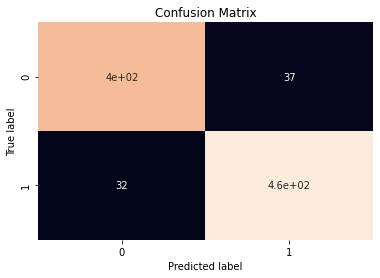

In [58]:
import time
start = time.time()
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
import seaborn as sns
clf = SVC()
clf.fit(Xtrain, Ytrain)
preds = clf.predict(Xtest)

print('Running time: %.4f seconds' % (time.time()-start))
print(accuracy_score(Ytest, preds))

cm = confusion_matrix(Ytest, preds)
sns.heatmap(cm, annot=True, cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
print(classification_report(Ytest, preds))

# Decsion tree

0.8270676691729323
              precision    recall  f1-score   support

           0       0.84      0.79      0.82       452
           1       0.81      0.86      0.84       479

    accuracy                           0.83       931
   macro avg       0.83      0.83      0.83       931
weighted avg       0.83      0.83      0.83       931



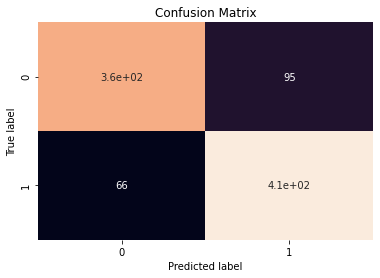

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
clf_des = DecisionTreeClassifier(max_depth =3, random_state = 42)
clf_des.fit(Xtrain, Ytrain)
preds_des=clf_des.predict(Xtest)

print(accuracy_score(Ytest, preds_des))
cm1 = confusion_matrix(Ytest, preds_des)
sns.heatmap(cm1, annot=True, cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
print(classification_report(Ytest, preds_des))

# Random forest

{'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       452
           1       0.92      0.92      0.92       479

    accuracy                           0.92       931
   macro avg       0.92      0.92      0.92       931
weighted avg       0.92      0.92      0.92       931



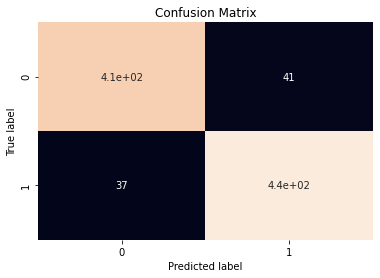

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#create a new random forest classifier
rf = RandomForestClassifier()
#create a dictionary of all values we want to test for n_estimators
params_rf = {'n_estimators': [50, 100, 200]}
#use gridsearch to test all values for n_estimators
rf_gs = GridSearchCV(rf, params_rf, cv=5)
#fit model to training data
rf_gs.fit(Xtrain, Ytrain)

#save best model
rf_best = rf_gs.best_estimator_
#check best n_estimators value
print(rf_gs.best_params_)
preds_rf=rf_best.predict(Xtest)
cm4 = confusion_matrix(Ytest, preds_rf)
sns.heatmap(cm4, annot=True, cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
print(classification_report(Ytest, preds_rf))

# KNN

              precision    recall  f1-score   support

           0       0.96      0.83      0.89       452
           1       0.86      0.97      0.91       479

    accuracy                           0.90       931
   macro avg       0.91      0.90      0.90       931
weighted avg       0.91      0.90      0.90       931

0.8990332975295381


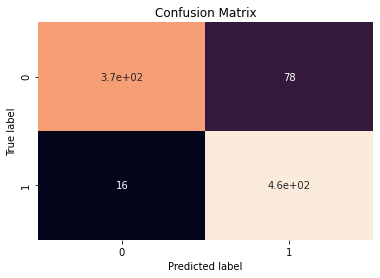

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
#create new a knn model
knn = KNeighborsClassifier()#create a dictionary of all values we want to test for n_neighbors

#fit model to training data
knn.fit(Xtrain, Ytrain)


#save best mod
preds_knn=knn.predict(Xtest)
cm6 = confusion_matrix(Ytest, preds_knn)
sns.heatmap(cm6, annot=True, cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
print(classification_report(Ytest, preds_knn))
print(knn.score(Xtest, Ytest))

# ensemble

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       452
           1       0.90      0.94      0.92       479

    accuracy                           0.92       931
   macro avg       0.92      0.91      0.91       931
weighted avg       0.92      0.92      0.92       931



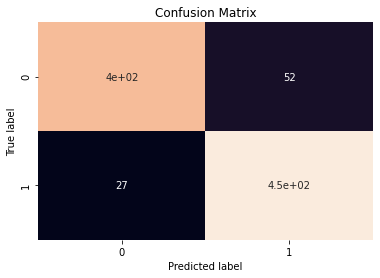

In [48]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[('knn', knn), ('rf', rf_best), ('svm', clf)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')
#fit model to training data
ensemble.fit(Xtrain, Ytrain)
#test our model on the test dat
preds_en=ensemble.predict(Xtest)
cm5 = confusion_matrix(Ytest, preds_en)
sns.heatmap(cm5, annot=True, cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
print(classification_report(Ytest, preds_en))

In [49]:
print(ensemble.score(Xtest, Ytest))

0.9151450053705693


# ELM

In [50]:
# Final edited date: 2018.3.7
# Author: Li Xudong, from NSSC.CAS Beijing
# Version: 1.0
# Description: Extreme Learning Machine (ELM) class
# Methods:
#   fit(algorithm)
#   predict(x)
#   score(x, y)
import numpy as np
from scipy.linalg import pinv2, inv
import time

class elm():
    '''
    Function: elm class init
    -------------------
    Parameters:
    shape: list, shape[hidden units, output units]
        numbers of hidden units and output units
    activation_function: str, 'sigmoid', 'relu', 'sin', 'tanh' or 'leaky_relu'
        Activation function of neurals
    x: array, shape[samples, features]
        train data
    y: array, shape[samples, ]
        labels
    C: float
        regularization parameter
    elm_type: str, 'clf' or 'reg'
        'clf' means ELM solve classification problems, 'reg' means ELM solve regression problems.
    one_hot: bool, Ture or False, default True 
        The parameter is useful only when elm_type == 'clf'. If the labels need to transformed to
        one_hot, this parameter is set to be True
    random_type: str, 'uniform' or 'normal', default:'normal'
        Weight initialization method
    '''
    def __init__(self, hidden_units, activation_function,  x, y, C, elm_type, one_hot=True, random_type='normal'):
        self.hidden_units = hidden_units
        self.activation_function = activation_function
        self.random_type = random_type
        self.x = x
        self.y = y
        self.C = C
        self.class_num = np.unique(self.y).shape[0]     
        self.beta = np.zeros((self.hidden_units, self.class_num))   
        self.elm_type = elm_type
        self.one_hot = one_hot

        # if classification problem and one_hot == True
        if elm_type == 'clf' and self.one_hot:
            self.one_hot_label = np.zeros((self.y.shape[0], self.class_num))
            for i in range(self.y.shape[0]):
                self.one_hot_label[i, int(self.y[i])] = 1

        # Randomly generate the weight matrix and bias vector from input to hidden layer
        # 'uniform': uniform distribution
        # 'normal': normal distribution
        if self.random_type == 'uniform':
            self.W = np.random.uniform(low=0, high=1, size=(self.hidden_units, self.x.shape[1]))
            self.b = np.random.uniform(low=0, high=1, size=(self.hidden_units, 1))
        if self.random_type == 'normal':
            self.W = np.random.normal(loc=0, scale=0.5, size=(self.hidden_units, self.x.shape[1]))
            self.b = np.random.normal(loc=0, scale=0.5, size=(self.hidden_units, 1))

    # compute the output of hidden layer according to different activation function
    def __input2hidden(self, x):
        self.temH = np.dot(self.W, x.T) + self.b

        if self.activation_function == 'sigmoid':
            self.H = 1/(1 + np.exp(- self.temH))

        if self.activation_function == 'relu':
            self.H = self.temH * (self.temH > 0)

        if self.activation_function == 'sin':
            self.H = np.sin(self.temH)

        if self.activation_function == 'tanh':
            self.H = (np.exp(self.temH) - np.exp(-self.temH))/(np.exp(self.temH) + np.exp(-self.temH))

        if self.activation_function == 'leaky_relu':
            self.H = np.maximum(0, self.temH) + 0.1 * np.minimum(0, self.temH)

        return self.H

    # compute the output
    def __hidden2output(self, H):
        self.output = np.dot(H.T, self.beta)
        return self.output

    '''
    Function: Train the model, compute beta matrix, the weight matrix from hidden layer to output layer
    ------------------
    Parameter:
    algorithm: str, 'no_re', 'solution1' or 'solution2'
        The algorithm to compute beta matrix
    ------------------
    Return:
    beta: array
        the weight matrix from hidden layer to output layer
    train_score: float
        the accuracy or RMSE
    train_time: str
        time of computing beta
    '''
    def fit(self, algorithm):
        self.time1 = time.clock()   # compute running time
        self.H = self.__input2hidden(self.x)
        if self.elm_type == 'clf':
            if self.one_hot:
                self.y_temp = self.one_hot_label
            else:
                self.y_temp = self.y
        if self.elm_type == 'reg':
            self.y_temp = self.y
        # no regularization
        if algorithm == 'no_re':
            self.beta = np.dot(pinv2(self.H.T), self.y_temp)
        # faster algorithm 1
        if algorithm == 'solution1':
            self.tmp1 = inv(np.eye(self.H.shape[0])/self.C + np.dot(self.H, self.H.T))
            self.tmp2 = np.dot(self.tmp1, self.H)
            self.beta = np.dot(self.tmp2, self.y_temp)
        # faster algorithm 2
        if algorithm == 'solution2':
            self.tmp1 = inv(np.eye(self.H.shape[0])/self.C + np.dot(self.H, self.H.T))
            self.tmp2 = np.dot(self.H.T, self.tmp1)
            self.beta = np.dot(self.tmp2.T, self.y_temp)
        self.time2 = time.clock()

        # compute the results
        self.result = self.__hidden2output(self.H)
        # If the problem if classification problem, the output is softmax
        if self.elm_type == 'clf':
            self.result = np.exp(self.result)/np.sum(np.exp(self.result), axis=1).reshape(-1, 1)

        # Evaluate training results
        # If problem is classification, compute the accuracy
        # If problem is regression, compute the RMSE
        if self.elm_type == 'clf':
            self.y_ = np.where(self.result == np.max(self.result, axis=1).reshape(-1, 1))[1]
            self.correct = 0
            for i in range(self.y.shape[0]):
                if self.y_[i] == self.y[i]:
                    self.correct += 1
            self.train_score = self.correct/self.y.shape[0]
        if self.elm_type == 'reg':
            self.train_score = np.sqrt(np.sum((self.result - self.y) * (self.result - self.y))/self.y.shape[0])
        train_time = str(self.time2 - self.time1)
        return self.beta, self.train_score, train_time

    '''
    Function: compute the result given data
    ---------------
    Parameters:
    x: array, shape[samples, features]
    ---------------
    Return:
    y_: array
        predicted results
    '''
    def predict(self, x):
        self.H = self.__input2hidden(x)
        self.y_ = self.__hidden2output(self.H)
        if self.elm_type == 'clf':
            self.y_ = np.where(self.y_ == np.max(self.y_, axis=1).reshape(-1, 1))[1]

        return self.y_

    '''
    Function: compute accuracy or RMSE given data and labels
    -------------
    Parameters:
    x: array, shape[samples, features]
    y: array, shape[samples, ]
    -------------
    Return:
    test_score: float, accuracy or RMSE
    '''
    def score(self, x, y):
        self.prediction = self.predict(x)
        if self.elm_type == 'clf':
            self.correct = 0
            for i in range(y.shape[0]):
                if self.prediction[i] == y[i]:
                    self.correct += 1
            self.test_score = self.correct/y.shape[0]
        if self.elm_type == 'reg':
            self.test_score = np.sqrt(np.sum((self.result - self.y) * (self.result - self.y))/self.y.shape[0])

        return self.test_score



In [51]:
model = elm(hidden_units=32, activation_function='relu', random_type='normal', x=Xtrain, y=Ytrain, C=0.1, elm_type='clf')
beta, train_accuracy, running_time = model.fit('solution2')

print("classifier train accuracy:", train_accuracy)
print('classifier running time:', running_time)

classifier train accuracy: 0.8538420204191295
classifier running time: 0.09377199999994446


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [52]:
prediction = model.predict(Xtest)
print("classifier test prediction:", prediction)
print('classifier test accuracy:', model.score(Xtest, Ytest))

classifier test prediction: [0 0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 0 1 1 1 1 1 1 0 1
 0 0 1 1 1 1 1 0 1 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 1 0 1
 1 1 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 1
 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0 1
 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 0 0 0 1
 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1
 1 0 0 0 1 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 1
 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1
 0 1 0 1 0 0 0 0 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 0 0 1 1 1 0 0 1 1 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0
 1 1 1 0 0 0 1 0 1 1 1 0 0 1 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1
 0 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 1 1 1 1 0 1 1 1 0 0
 0 1 0 0 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1 1 1 0 0 0 1 1 0 1 0 0 1

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       452
           1       0.85      0.89      0.87       479

    accuracy                           0.86       931
   macro avg       0.86      0.86      0.86       931
weighted avg       0.86      0.86      0.86       931



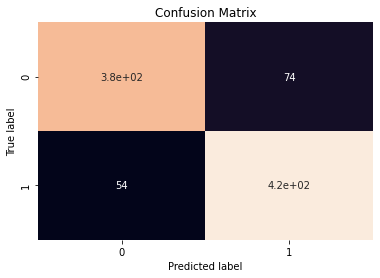

In [53]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
preds_elm=model.predict(Xtest)
cm8 = confusion_matrix(Ytest, preds_elm)
sns.heatmap(cm8, annot=True, cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
print(classification_report(Ytest, preds_elm))